In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
from scipy import stats, integrate, optimize, interpolate, linalg
import numba

## Time-dependent models

In [2]:
def Psi_td(Phi, beta):
    Phibeta = Phi*beta**np.arange(len(Phi))
    constant = 1/(Phi.sum()*Phibeta.sum())
    left_matrix = np.tril(linalg.toeplitz(Phi))
    right_matrix = np.triu(linalg.toeplitz(Phibeta))
    return constant * left_matrix @ right_matrix

In [3]:
def K_from_Psi(Psi):
    K = np.linalg.solve(np.eye(len(Psi)) - Psi, Psi)
    K[1:] -= K[:-1]
    return K

First, look at the Calvo case:

In [4]:
T = 1000
theta = 0.75
beta = 0.975
Phi = theta**np.arange(T)
Psi = Psi_td(Phi, beta)
K = K_from_Psi(Psi)

Visualize the pass-through matrix:

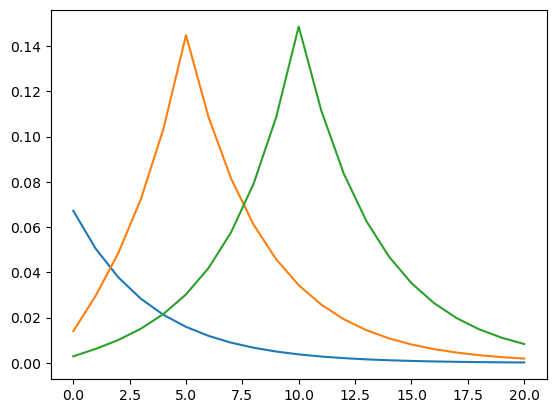

In [5]:
plt.plot(Psi[:21, [0, 5, 10]]);

In [6]:
Psi[:, 0].sum()

0.26875

In [7]:
Psi[:, 30].sum()

0.9999388998534655

Visualize the generalized Phillips curve, which here is the standard Calvo New Keynesian Phillips curve:

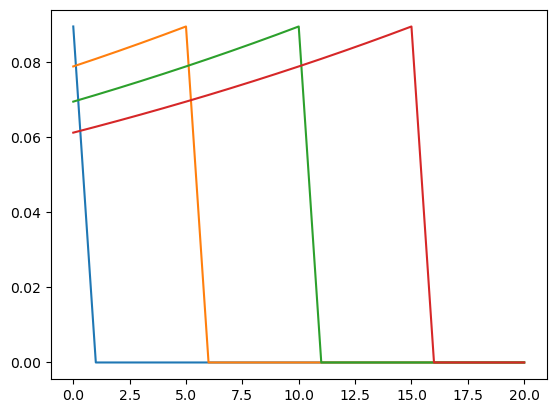

In [8]:
plt.plot(K[:21, [0, 5, 10, 15]]);

Alternatively, what if we have Taylor pricing? Then things look pretty weird, with a bit of inertia:

In [9]:
Phi = np.zeros(T)
Phi[:4] = 1
Psi = Psi_td(Phi, beta)
K = K_from_Psi(Psi)

Triangular pass-through matrix:

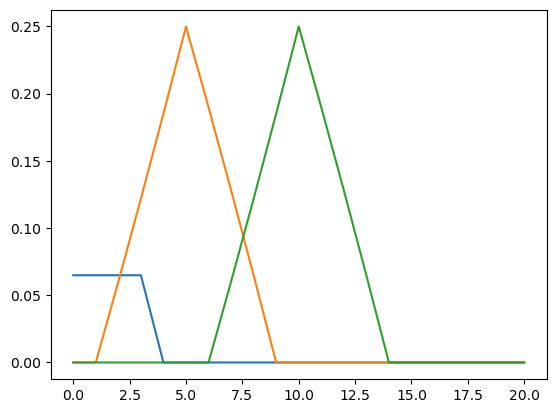

In [10]:
plt.plot(Psi[:21, [0, 5, 10]]);

Strange-looking generalized Phillips curve, with a bit of inertia past the dates of the shocks (but not more than a few periods). Note that the scale for the anticipated shocks, although not the date 0 shock, is similar to that of the Calvo NKPC, which we calibrated to the same quarterly frequency of price changes (0.25):

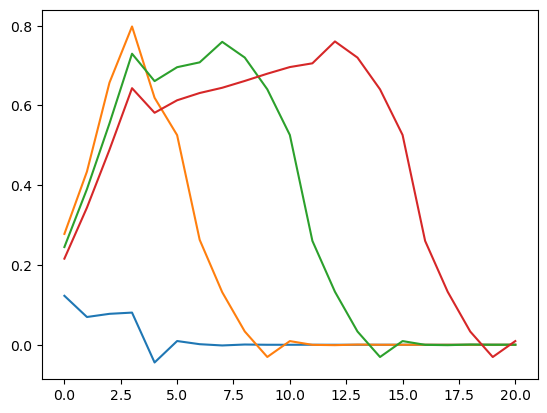

In [11]:
plt.plot(K[:21, [0, 5, 10, 15]]);

Interestingly, the response to a far-out shock still has the same low decay rate of $\beta$:

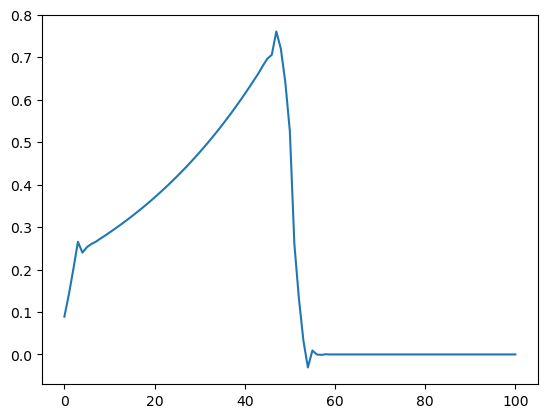

In [12]:
plt.plot(K[:101, 50]);

In [13]:
K[20, 50] / K[21, 50], beta

(0.9750000014278929, 0.975)

Let's try a smoother time-dependent case with an increasing hazard rate, which I arbitrarily specify to converge to 0.5 from below, starting from 0:

In [14]:
lamb = 0.5*(1 - 0.8 ** np.arange(T-1))
Phi = np.ones(T)
Phi[1:] = np.cumprod(1-lamb) # survival from 1 onward is cumulative product of 1-hazard

Plot hazard:

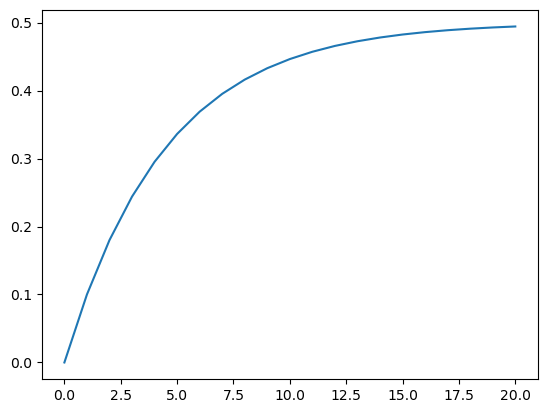

In [15]:
plt.plot(lamb[:21]);

Plot survival:

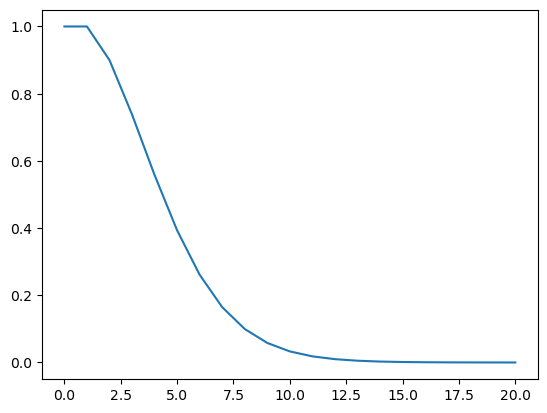

In [16]:
plt.plot(Phi[:21]);

Now, what does the generalized Phillips curve look like? Still a bit of inertia, for the same reasons as with Taylor pricing, but not as much as we might want:

In [17]:
Psi = Psi_td(Phi, beta)
K = K_from_Psi(Psi)

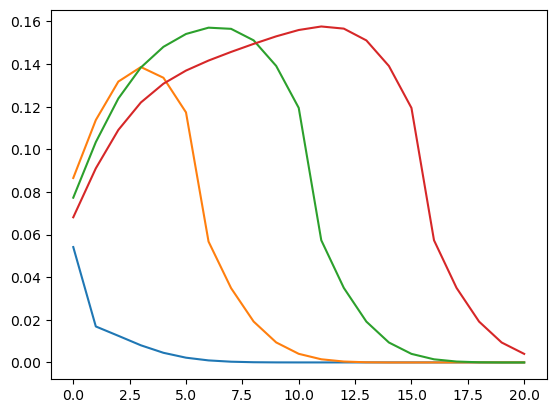

In [18]:
plt.plot(K[:21, [0, 5, 10, 15]]);

# Simple menu cost model

### Calibration

Let's first calibrate a simple menu cost model as discussed in the lecture notes, where the shocks follow $\epsilon \sim \mathcal{N}(0,\sigma^2)$ for some standard deviation $\sigma$, and in the steady state the SS bands are $[-\bar{x},\bar{x}]$, with a reset point of $x^*=0$.

In principle, we could solve the steady-state Bellman equation for the model to obtain the optimal $\bar{x}$ given a menu cost of $\xi$. But when we calibrate the model, we will generally do so in order to hit a given frequency of price changes anyway (say, to match the data, or to be consistent with our calibration choice for another model). So we can skip the step of calibating the menu cost $\xi$ itself, instead just directly finding the $\bar{x}$ that hits a given frequency of price changes—say, 0.25 each quarter, to match our Calvo and Taylor calibrations.

First, we need to write a function that obtains the steady-state density $g(x)$ on the interval $[-\bar{x},\bar{x}]$. We'll represent it as a cubic spline (here, a piecewise cubic function with continuous first and second derivatives), and use the relationships:

$$
\text{freq} = 1 - \int_{-\bar{x}}^{\bar{x}} g(x)dx
$$

$$
g(x) = \text{freq}\cdot f(x) + \int_{-\bar{x}}^{\bar{x}} f(x-x')g(x')dx'
$$

where $\text{freq}$ is the frequency of adjustment and $f(\cdot)$ is the pdf of the shocks $\epsilon$. The first equation simply says that any price gap that isn't in the interval $[-\bar{x},\bar{x}]$ is reset, and the second equation says that the density at any point equals the sum of the density from those who reset last period (who start at zero and then get a shock distributed according to $f$) and the density from those who did not reset last period.

Implementing these, first writing a function for the normal pdf:

In [19]:
C = 1/np.sqrt(2*np.pi)
def normal_pdf(x, sigma):
    return C/sigma*np.exp(-(x/sigma)**2/2)

In [20]:
sigma = 0.05 # roughly the calibrated value in our New Pricing Models paper
def f(x):
    return normal_pdf(x, sigma)

In [21]:
def ss_dist(xbar):
    xs = np.linspace(-xbar, xbar, 50) # 50 nodes for cubic spline
    gxs = np.full(50, 1/(2*xbar)) # initially guess uniform
    g = interpolate.CubicSpline(xs, gxs)
    
    for it in range(100):
        freq = 1 - g.integrate(-xbar, xbar) # c
        gxs_new = (freq*f(xs) 
            + np.array([integrate.quad(lambda xp: f(xp - x)*g(xp), -xbar, xbar)[0] for x in xs]))
        g = interpolate.CubicSpline(xs, gxs_new)
        
        if np.max(np.abs(gxs_new - gxs)) < 1E-10:
            return g
        gxs = gxs_new
        
    raise ValueError('No convergence')

Let's see what the density looks like for an arbitrary $\bar{x}$, and what the implied frequency is:

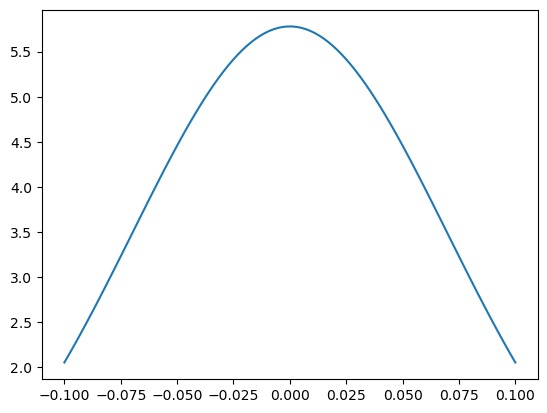

In [22]:
xbar = 0.1
g = ss_dist(xbar)
xs = np.linspace(-xbar, xbar, 100)
plt.plot(xs, g(xs));

In [23]:
freq = 1 - g.integrate(-xbar, xbar)
freq

0.14464449647733557

Now let's solve to hit $\text{freq}=0.25$, noting that we'll need a smaller $\bar{x}$ than in the above example:

In [24]:
xbar = optimize.brentq(lambda xbar: ss_dist(xbar).integrate(-xbar, xbar) - 0.75, 0.01, 0.1)
xbar

0.06779121697571124

In [25]:
g = ss_dist(xbar)
freq = 1 - g.integrate(-xbar, xbar)
freq

0.2499999999999909

So what does the actual density look like?

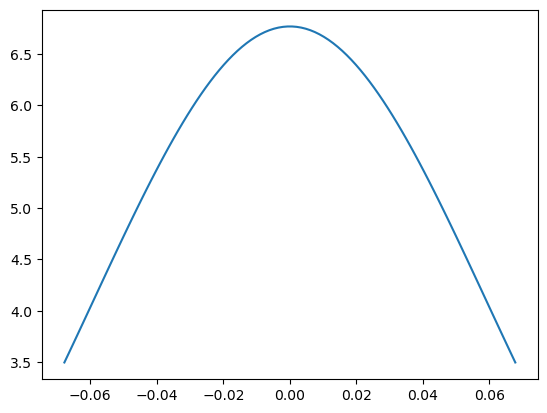

In [26]:
xs = np.linspace(-xbar, xbar, 100)
plt.plot(xs, g(xs));

### Recursion to obtain $E^t(x)$ functions

Now we've successfully calibrated the model such that the frequency of price adjustment is 0.25. Let's obtain the *expectation functions* $E^t(x)$ on $[-\bar{x},\bar{x}]$, again represented as a cubic spline with 50 nodes. This is even easier than our previous iteration.

(Note: this is not particularly efficient Python code—we could probably speed this up by a factor of at least 100 if we needed to by replacing the general `quad` integration with manual quadrature, and writing the code so that the calls to the cubic spline are all done at once. But this is fast enough for our purposes.)

In [27]:
xs = np.linspace(-xbar, xbar, 50)

In [28]:
def E_recursion(E):
    Exs = [integrate.quad(lambda xp: f(xp - x)*E(xp), -xbar, xbar)[0] for x in xs]
    return interpolate.CubicSpline(xs, Exs)

We can calculate a few individual expectation functions and plot them:

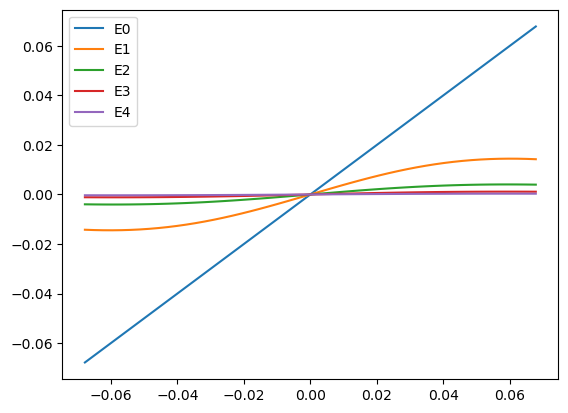

In [29]:
E0 = lambda x: x
Es = [E0]
for i in range(4):
    Es.append(E_recursion(Es[-1]))

for i in range(5):
    plt.plot(xs, Es[i](xs), label=f'E{i}')
plt.legend();

Or ignore the first so that we see what these tend to look like:

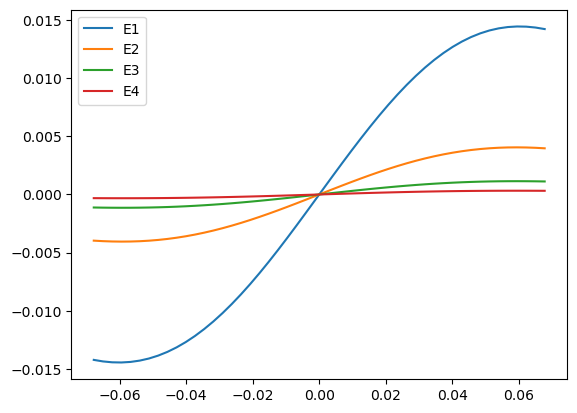

In [30]:
for i in range(1, 5):
    plt.plot(xs, Es[i](xs), label=f'E{i}')
plt.legend();

Note that these tend to decay at a rate much faster than the probability 0.25 of resetting prices.

In [31]:
Es[4](xbar)/Es[3](xbar)

0.2821683621852324

In [32]:
Es[3](xbar)/Es[2](xbar)

0.28206053488997634

### Virtual survival functions
The "virtual survival functions" for the extensive and intensive margins are given by $\Phi_t^e = E^t(\bar{x})/\bar{x}$ and $\Phi_t^i = E^{t\prime}(0)$. Let's calculate these up to 30 (beyond that, we'll see that they are near zero):

In [33]:
TPhi = 30
Phi_e = np.empty(TPhi)
Phi_i = np.empty(TPhi)

Et = interpolate.CubicSpline(xs, xs) # identity
for t in range(TPhi):
    Phi_e[t] = Et(xbar)/xbar
    Phi_i[t] = Et.derivative()(0)
    Et = E_recursion(Et)

See that these are indeed near-zero by the end:

In [34]:
Phi_e[-3:], Phi_i[-3:]

(array([1.07254697e-15, 3.02643184e-16, 8.53975566e-17]),
 array([2.05877717e-15, 5.80930183e-16, 1.63922489e-16]))

Let's plot them up to $t=10$:

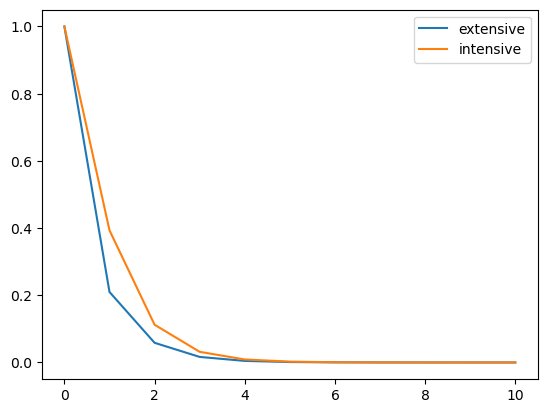

In [35]:
plt.plot(Phi_e[:11], label='extensive')
plt.plot(Phi_i[:11], label='intensive')
plt.legend();

What do the hazards $\lambda_t = 1-\Phi_{t+1}/\Phi_t$ look like? We see almost immediate convergence to identical, *very* high levels. Note that this hazard, of over 0.7, is *far* higher than the rate 0.25 of price adjustment.

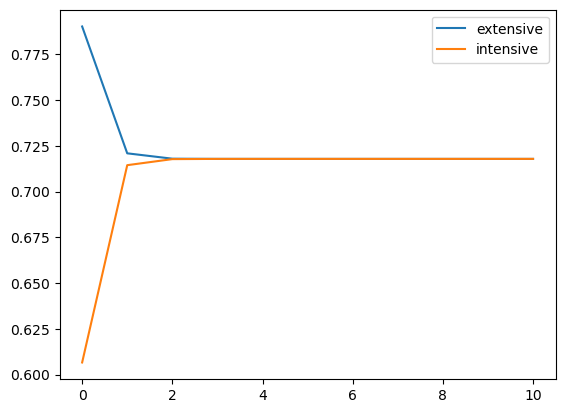

In [36]:
lamb_e = 1 - Phi_e[1:] / Phi_e[:-1]
lamb_i = 1 - Phi_i[1:] / Phi_i[:-1]
plt.plot(lamb_e[:11], label='extensive')
plt.plot(lamb_i[:11], label='intensive')
plt.legend();

Why does the virtual hazard initially start lower for the intensive margin vs. the extensive margin? Because starting at $x^*=0$, you're not likely to adjust right away, whereas at $\bar{x}$, you're very likely to adjust.

Note that we can use the same expectation recursion, applied to an initial condition of 1, to get the probability that a price gap of $x$ will *not* be reset in $t$ periods. Let's keep track of the probability for $x^*=0$, which we might call the "actual" survival probability (as opposed to the virtual). Also, let's plot the first few.

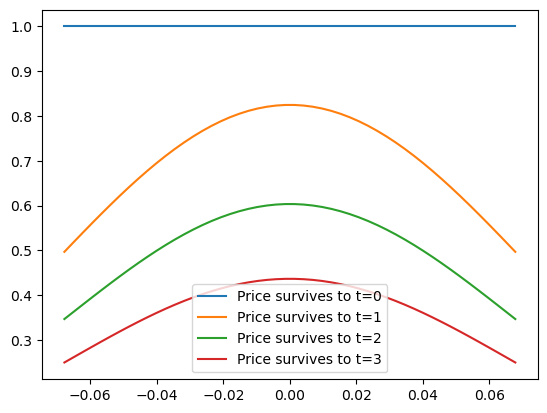

In [37]:
TPhi = 30
Phi_actual = np.empty(TPhi)
Et_noreset = interpolate.CubicSpline(xs, np.ones(len(xs)))
for t in range(TPhi):
    if t < 4:
        plt.plot(xs, Et_noreset(xs), label=f'Price survives to t={t}')
    Phi_actual[t] = Et_noreset(0)
    Et_noreset = E_recursion(Et_noreset)
plt.legend();

We see that these approach a different, even eigenfunction, with much slower decay.

Plot the actual survival hazard vs. the two virtual survival hazards:

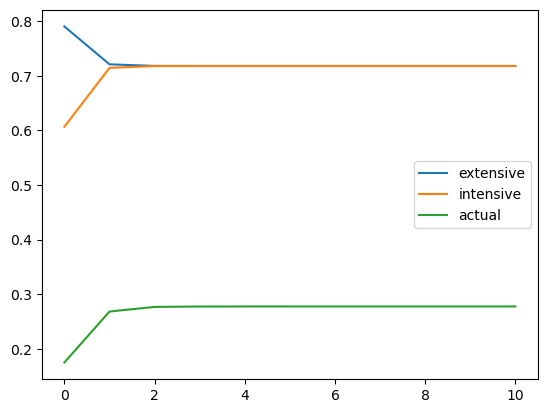

In [38]:
lamb_actual = 1 - Phi_actual[1:] / Phi_actual[:-1]
plt.plot(lamb_e[:11], label='extensive')
plt.plot(lamb_i[:11], label='intensive')
plt.plot(lamb_actual[:11], label='actual')
plt.legend();

We see that it converges to a much lower level, slightly above the average frequency 0.25 of adjustment. (This latter point makes sense: the asymptotic survival hazard should be above 0.25 given that the hazard immediately after adjustment is 0.25, and they need to average out to 0.25.)

This contrast is an example of the *selection effect*: our expectation of future price gaps decays very quickly—much faster than the actual rate at which we'll reset prices—because, if we don't adjust, price gaps have been selected toward zero. 

### Obtaining the relevant pass-through matrix and generalized Phillips curve
First, obtain the pass-through matrices corresponding to the extensive and intensive margins. We'll pad the $\Phi$s with zeros.

In [39]:
Phi_e_long = np.zeros(T)
Phi_e_long[:TPhi] = Phi_e
Psi_e = Psi_td(Phi_e_long, beta)

Phi_i_long = np.zeros(T)
Phi_i_long[:TPhi] = Phi_i
Psi_i = Psi_td(Phi_i_long, beta)

Finally, to obtain the overall pass-through matrix, we need the weight $\alpha$ on the extensive margin:

In [40]:
alpha = 2*g(xbar)*xbar*Phi_e.sum()
alpha

0.6125302164427192

In [41]:
Psi = alpha*Psi_e + (1-alpha)*Psi_i

It's sharply spiked, corresponding to the rapidly declining virtual survival:

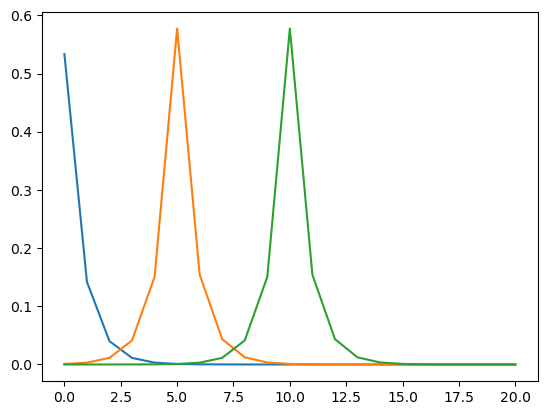

In [42]:
plt.plot(Psi[:21, [0, 5, 10]]);

In [43]:
K = K_from_Psi(Psi)

We end up with a New Keynesian Phillips curve that looks almost identical to what we had before, just with vastly, vastly higher slope (something like 20 times higher):

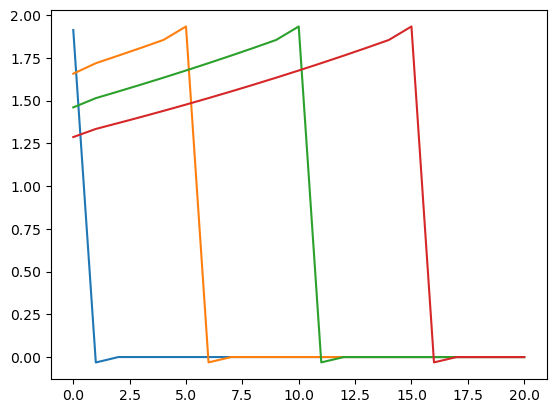

In [44]:
plt.plot(K[:21, [0, 5, 10, 15]]);

## What about with "free resets"?
A common modification of this model is to add "free resets": a probability that the menu cost is zero and that therefore we will want to reset prices for free. This is sometimes called the "Calvo-plus" model (Nakamura-Steinsson), because price changes are a combination of the Calvo fairy visiting and then changes once we leave the adjustment bands.

Let's repeat the steps, which are almost identical, in this model, assuming a free reset rate of $.2$, and still calibating to an overall frequency of $\text{freq}=.25$. This means that the model will feature 80% Calvo-like price changes and 20% elective price changes where firms are willing to pay the menu cost.

Calibration is similar, where the only modification to our iteration over $g$ is that we add a coefficient of .8 to the two integrals. Here, we need to think of $g$ as being the *pre-adjustment* density:

In [45]:
lamb = .2

In [46]:
def ss_dist(xbar, tol=1E-7):
    xs = np.linspace(-xbar, xbar, 50) # use 50 nodes for cubic spline
    gxs = np.full(50, 1/(2*xbar)) # initially guess uniform
    g = interpolate.CubicSpline(xs, gxs)
    
    for it in range(120):
        freq = 1 - (1-lamb)*g.integrate(-xbar, xbar)
        gxs_new = (freq*f(xs) 
            + np.array([integrate.quad(lambda xp: (1-lamb)*f(xp - x)*g(xp), -xbar, xbar)[0] for x in xs]))
        g = interpolate.CubicSpline(xs, gxs_new)
        
        if np.max(np.abs(gxs_new - gxs)) < tol:
            return g
        gxs = gxs_new
        
    raise ValueError('No convergence')

We need a wider adjustment band (because the number of resets from being outside the bands is calibrated to be lower), and convergence takes longer. There are also some funny numerical problems at high precision, so we have a bit less demanding criterion for stopping:

In [47]:
xbar = optimize.brentq(lambda xbar: (1-lamb)*ss_dist(xbar).integrate(-xbar, xbar) - 0.75, 0.1, 0.15)
xbar

0.13854977072202138

In [48]:
g = ss_dist(xbar, tol=1E-10)
freq = 1 - (1-lamb)*g.integrate(-xbar, xbar)
freq

0.2500000003282118

What does the density look like now? It declines much more near the edges than before, much different from uniform:

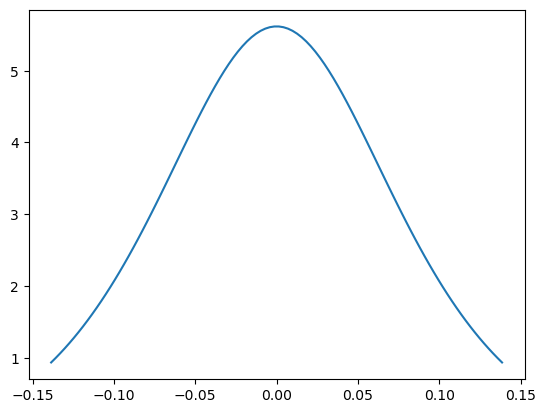

In [49]:
xs = np.linspace(-xbar, xbar, 100)
plt.plot(xs, g(xs));

Similarly, we need to redo the expectation recursion, which here is again very simple, just adding an extra factor of 0.8:

In [50]:
xs = np.linspace(-xbar, xbar, 50)
def E_recursion(E):
    Exs = [integrate.quad(lambda xp: (1-lamb)*f(xp - x)*E(xp), -xbar, xbar)[0] for x in xs]
    return interpolate.CubicSpline(xs, Exs)

In [51]:
TPhi = 50
Phi_e = np.empty(TPhi)
Phi_i = np.empty(TPhi)
Phi_actual = np.empty(TPhi)

Et = interpolate.CubicSpline(xs, xs) # identity
Et_noreset = interpolate.CubicSpline(xs, np.ones(len(xs)))

for t in range(TPhi):
    Phi_e[t] = Et(xbar)/xbar
    Phi_i[t] = Et.derivative()(0)
    Phi_actual[t] = Et_noreset(0)
    Et = E_recursion(Et)
    Et_noreset = E_recursion(Et_noreset)

Decay is much slower, so even going out to 50 these aren't quite zero:

In [52]:
Phi_e[-3:], Phi_i[-3:]

(array([1.63192268e-14, 8.44521745e-15, 4.37040912e-15]),
 array([6.39507445e-14, 3.30945791e-14, 1.71264803e-14]))

Plot these vs. the actual hazards:

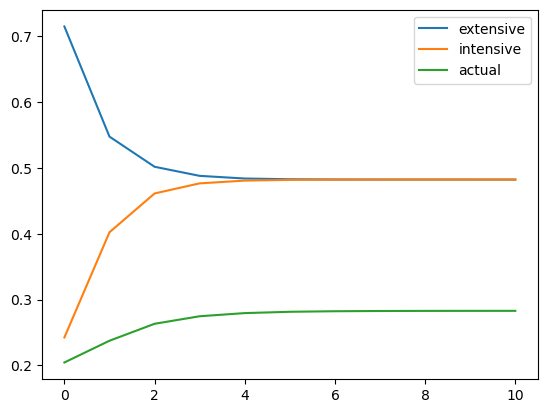

In [53]:
lamb_e = 1 - Phi_e[1:] / Phi_e[:-1]
lamb_i = 1 - Phi_i[1:] / Phi_i[:-1]
lamb_actual = 1 - Phi_actual[1:] / Phi_actual[:-1]
plt.plot(lamb_e[:11], label='extensive')
plt.plot(lamb_i[:11], label='intensive')
plt.plot(lamb_actual[:11], label='actual')
plt.legend();

The thing to notice here is that the selection effect is less strong: the actual hazard is about the same as before, but the extensive and intensive hazards limit to something lower, so that the gap is smaller. This makes sense: only a fraction of price adjustments are done in a "selected" way, with the rest being Calvo.

Also, it takes longer for the intensive and extensive hazards to converge to the same levels. This is a result of the wider adjustment bands: it takes longer before the difference between starting at 0 and starting at $\bar{x}$ washes out.

Now, calculate the pass-through matrices:

In [54]:
Phi_e_long = np.zeros(T)
Phi_e_long[:TPhi] = Phi_e
Psi_e = Psi_td(Phi_e_long, beta)

Phi_i_long = np.zeros(T)
Phi_i_long[:TPhi] = Phi_i
Psi_i = Psi_td(Phi_i_long, beta)

The weight on the extensive margin is adjusted downward by 0.8 but is otherwise the same formula. Note that the weight is also lower also simply because the density $g(\bar{x})$ is lower than before—fewer pricesetters make it all the way to the extensive margin:

In [55]:
alpha = 2*(1-lamb)*g(xbar)*xbar*Phi_e.sum()
alpha

0.3202811425659613

We get a less sharply spiked pass-through matrix:

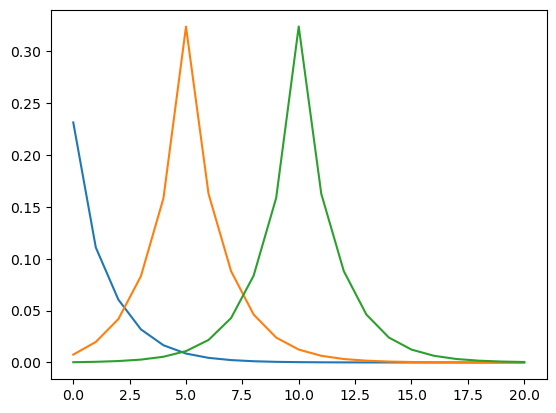

In [56]:
Psi = alpha*Psi_e + (1-alpha)*Psi_i
plt.plot(Psi[:21, [0, 5, 10]]);

The generalized Phillips curve still looks very similar to the standard New Keynesian Phillips curve, but the functional form is a bit less of a close match. This turns out to be traceable to the fact that the intensive and extensive hazards don't converge to a constant (a constant hazard is Calvo) as quickly, so the model behaves a bit less Calvo-like in that sense.

Quantitatively, though, it's much closer to Calvo, with the Phillips curve having a slope that's maybe only 5 times greater than what we had before, rather than 20. This is because the "selection effect" is weaker.

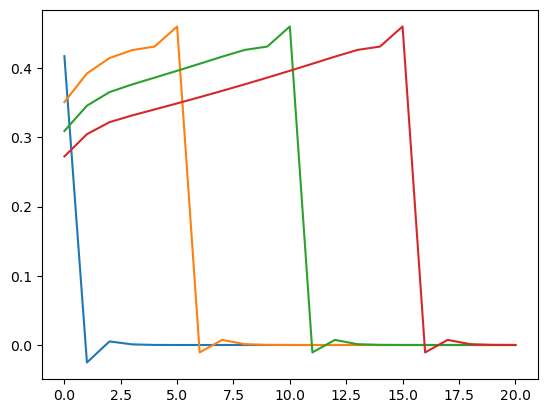

In [57]:
K = K_from_Psi(Psi)
plt.plot(K[:21, [0, 5, 10, 15]]);

# Sticky expectations
Now that we know that menu cost models produce essentially the same results as a Calvo model (just with a higher slope of the New Keynesian Phillips curve), let's return to the Calvo model, but consider adding sticky expectations as we introduced in lecture 9.

Repeat the code from the previous lecture that manipulates Jacobians and adds sticky expectations.

In [58]:
@numba.njit
def behavioral_J(J, E):
    T = len(J)
    Jnew = E[0, :] * J
    for t in range(T):
        for s in range(T):
            for tau in range(1, min(t, s)+1):
                Jnew[t, s] += (E[tau, s] - E[tau-1, s])*J[t-tau, s-tau]
    return Jnew

In [59]:
def E_stickyexp(theta, T):
    E_stickyinfo = np.outer(1 - theta**(1+np.arange(T)), np.ones(T))
    return np.maximum(E_stickyinfo, np.tril(np.ones((T, T))))

Now, assuming that households have sticky expectations with persistence 0.75 (the same as the Calvo stickiness of prices) about both the shock to real marginal cost and the overall price level, we have:

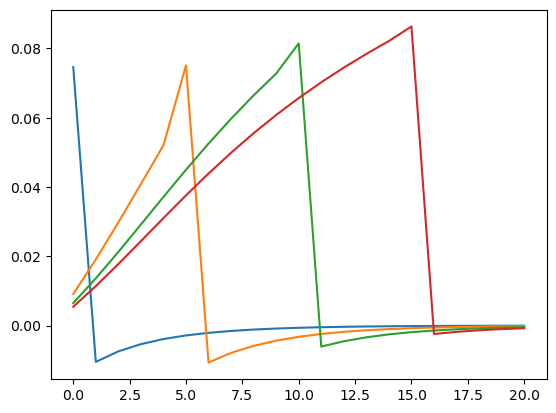

In [60]:
E_se = E_stickyexp(0.75, T)
Psi_calvo = Psi_td(0.75**np.arange(T), beta)
Psi_calvo_se = behavioral_J(Psi_calvo, E_se)
K_calvo_se = K_from_Psi(Psi_calvo_se)
plt.plot(K_calvo_se[:21, [0, 5, 10, 15]]);

Clearly, the initial response to a future shock is a lot smaller.

Suppose that we have an AR(1) shock with a persistence of 2 years—what will the impulse response to that look like?

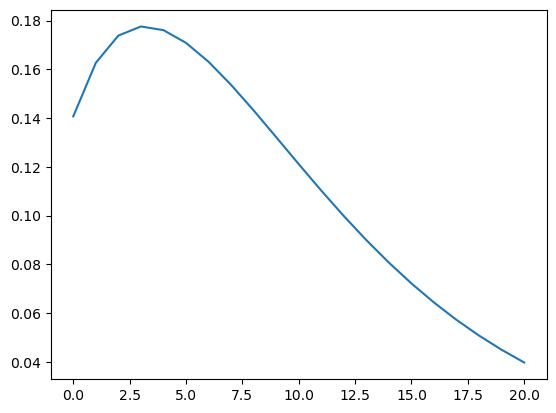

In [61]:
plt.plot((K_calvo_se @ 0.875**np.arange(T))[:21]);

Here we get some of what we want in terms of "inertial" behavior, with a hump on impact. It's important to note, however, that once the real marginal cost shock has passed, the inflation response here is actually negative. We have initial *underreaction* to the future shock, but we don't have any response to past shocks.

We can also, in principle, suppose that there are no sticky expectations about the real marginal cost shock itself, but there are sticky expectations about changes in the price level. This means that we need to include the modified $\Psi^{se}$ only in the inverse:

In [62]:
K_partial_se = np.linalg.solve(np.eye(T) - Psi_calvo_se, Psi_calvo)
K_partial_se[1:] -= K_partial_se[:-1]

We plot the new calculation in the dashed line. We note that there's less underreaction to near-term shocks, but even just having sticky expectations about prices means that there is roughly the same amount of underreaction to shocks that are far in the future — an indication that most of the anticipated response is coming from the response to others' price-setting, rather than the direct pricing response.

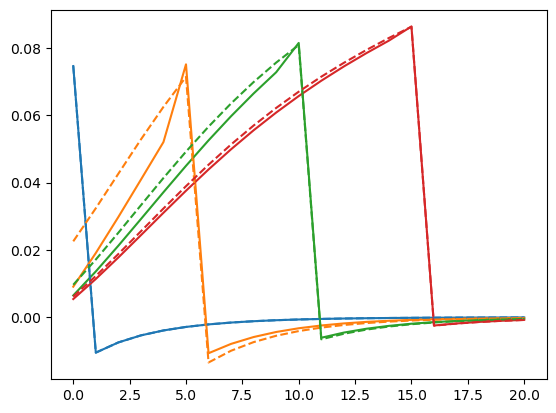

In [63]:
plt.plot(K_calvo_se[:21, [0, 5, 10, 15]])
plt.gca().set_prop_cycle(None)
plt.plot(K_partial_se[:21, [0, 5, 10, 15]], '--');

We can have even slightly stronger effects if we assume that firms do not know information from the current period when setting prices (which we ruled out in our specification above)—this would require a slight change in the code.

# Mixture models: dispersion across sectors
What if the aggregate 0.25 rate of price change is the combination of a sector with 0.2 weight that changes its price every quarter (so that it's perfectly flexible), and a remaining sector with weight 0.8 that changes its price with a rate of only 0.0625?

In [64]:
Psi_sticky = Psi_td((1-0.0625)**np.arange(T), beta)
Psi_mixture = 0.8*Psi_sticky + 0.2*np.eye(T)

What we get here are huge up-and-down responses determined by the flexible sector, without much anticipation at all:

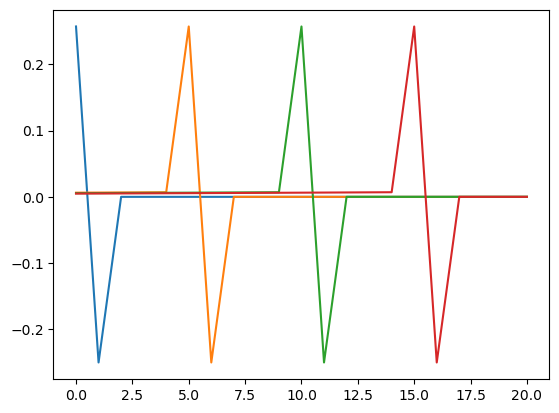

In [65]:
K_mixture = K_from_Psi(Psi_mixture)
plt.plot(K_mixture[:21, [0, 5, 10, 15]]);

If we plot the response of the mixture model vs. the purely sticky-price model in anticipation of the shock, they're surprisingly similar in magnitude, just a bit more than 20% off. The slope of the response is very low:

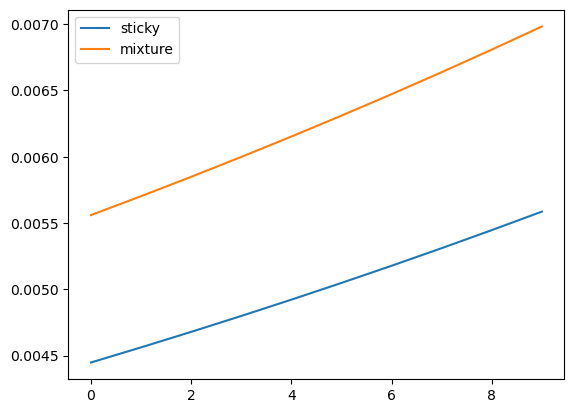

In [66]:
K_sticky = K_from_Psi(Psi_sticky)
plt.plot(K_sticky[:10, 10], label='sticky');
plt.plot(K_mixture[:10, 10], label='mixture');
plt.legend();

The slightly-more-than-20%-off result is no coincidence: it corresponds to the weight of the flexible pricers being about 20%. We see here that the long-term dynamics of pricing are dominated by the sticky pricers here, not the flexible pricers - which is a way, perhaps, to match a relatively low slope of the Phillips curve.

What if we do a less extreme mix? Say, there is a measure 0.3 of pricesetters who are quite but not perfectly flexible (50% chance), and then the rest are determined residually to hit the target of 25% quarterly adjustment?

In [67]:
theta_flexible = 0.5
theta_sticky = (0.75 - 0.3*theta_flexible)/0.7
1 - theta_sticky

0.1428571428571428

In [68]:
Psi_flexible = Psi_td(theta_flexible**np.arange(T), beta)
Psi_sticky = Psi_td(theta_sticky**np.arange(T), beta)
Psi_mixture = 0.3*Psi_flexible + 0.7*Psi_sticky
K_mixture = K_from_Psi(Psi_mixture)

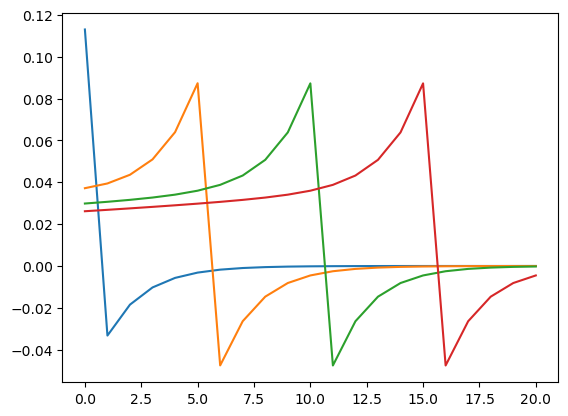

In [69]:
plt.plot(K_mixture[:21, [0, 5, 10, 15]]);

Now we still have anti-persistence, but a bit less extreme than before. The overall level of the curve, ignoring the part very close to the shock, is much more similar to the magnitude implied by the sticky pricers:

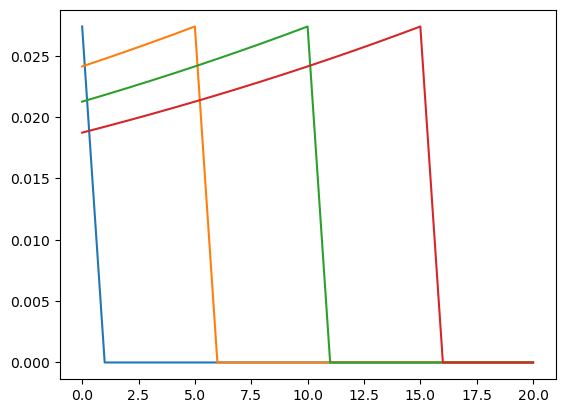

In [70]:
K_sticky = K_from_Psi(Psi_sticky)
plt.plot(K_sticky[:21, [0, 5, 10, 15]]);

Than to the magnitude implied by the flexible pricers, which would be enormous:

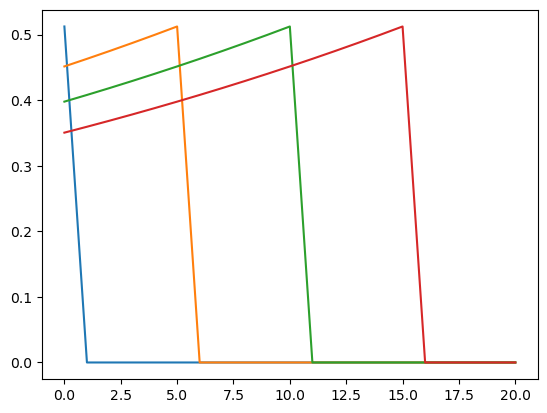

In [71]:
K_flexible = K_from_Psi(Psi_flexible)
plt.plot(K_flexible[:21, [0, 5, 10, 15]]);